# Ficha de Trabalho 1

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.optimize import basinhopping

Criar o modelo para a bactéria BL21

In [3]:
# Model bl21
def bl21(t, Y, k, miu_max, ks, fb=[]):
	"""
	This will be the model for the strain BL21

	:param ks:
	:param miu_max:
	:param fb_params:
	:param t: time; This argument should not be altered
	:param Y: initial conditions; array-like data structure (list, tuple, numpy array)
	:param K_params: Estimated K parameters; array-like data structure (list, tuple, numpy array)
	:param fb_params: Optional set of  parameters that set the model into FeedBatch mode if provided; array-like data structure (list, tuple, numpy array)
	:return: K * phi - (D (F/V) * variables) + zeros; note that numpy.dot() is the standard for matrices multiplication

	"""
	# operations mode

	# Calculate per reaction miu
	m = [Y[1], Y[1], Y[2]]
	miu = [miu_max[i]*(m[i]/(ks[i]+m[i])) for i in range(3)]

	# batch (basic) logic
	
	def batch():
		dXdt = miu[0]*Y[0] + miu[1]*Y[0] + miu[2]*Y[0]
		dSdt = (-k[0])*miu[0]*Y[0] - k[1]*miu[1]*Y[0]
		dAdt = k[2]*miu[1]*Y[0] - k[3]*miu[2]*Y[0]
		dPdt = k[10]*miu[0]*Y[0]
		dVdt = 0
		return [dXdt, dSdt, dAdt, dPdt, dVdt]

	def feedbatch(func):
		D = fb[0]/Y[4] # Fe/V
		dilution = [-D*k[0], D*fb[1] -D*k[1], -D*k[2], -D*k[3], fb[0]]
		return np.add(func,dilution)

	if fb:
		return feedbatch(batch())
	else:
		return batch()

## a)-b)

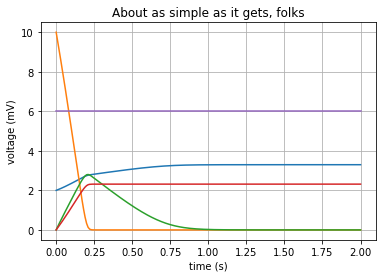

In [4]:
# Initial conditions
# y0 = [3, 8, 0, 0, 4]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
# params = [3.164, 25.22, 10.90, 6.382, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 10.0]
# miu_max = [0.3, 0.6, 0.2]
# ks = [0.2, 0.2, 0.5]
y0 = [2,10,0,0,6]
miu_max = [0.6,0.9,0.5]
ks = [0.5,0.5,0.8]
params = [4.994,23.44,9.88,5.456, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 9.3]
# Initial time
t0 = 0
fb_params = []
# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(bl21).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params, miu_max, ks)

# Final time and step
t1 = 2
dt = 0.01

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''

while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, Y)
ax.set(xlabel='time (s)', ylabel='voltage (mV)',title='About as simple as it gets, folks')
ax.grid()
plt.show()

## c)-d)

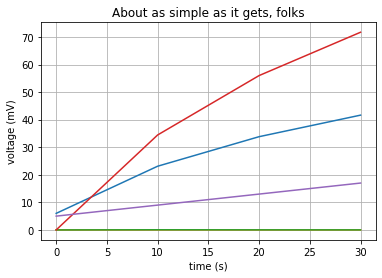

In [5]:
# Initial conditions
# y0 = [2, 0, 0, 0, 3]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
y0 = [6,0,0,0,5]
miu_max = [0.6,0.9,0.5]
ks = [0.5,0.5,0.8]
params = [4.994,23.44,9.88,5.456, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 9.3]
fb_params = [0.4, 300]

# Initial time
t0 = 0

# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(bl21).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params, miu_max, ks, fb_params)

# Final time and step
t1 = 30
dt = 10

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''
while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, Y)
ax.set(xlabel='time (s)', ylabel='voltage (mV)',title='About as simple as it gets, folks')
ax.grid()
fig.savefig("test.png")
plt.show()

## e)

Criar modelo para a bactéria JM109

In [61]:
def jm109(t, Y, params):
"""

This will be the model for the strain JM109 which is similar to the BL21, but it should have slight modifications

:param t: time; This argument should not be altered
:param Y: initial conditions; array-like data structure (list, tuple, numpy array)
:param params: parameters; array-like data structure (list, tuple, numpy array) - NOTE THAT THESE ARGUMENT MUST
CONTAIN ONLY AND ONLY THOSE PARAMETERS TO BE ESTIMATED. The remain parameters should be hardcoded within the
function
:return: K * phi - (D * variables) + zeros; note that numpy.dot() is the standard for matrices multiplication

"""
return

IndentationError: expected an indented block (<ipython-input-61-aab3548c57b3>, line 14)

Criar função para estimação dos parâmetros

In [ ]:
def estimate(params):

"""

This will be our estimate function that works out as the calculation of the difference between the experimental
and predicted values and can be used as the objective function

:param params: parameters; array-like data structure (list, tuple, numpy array) for the ode
:return: the error between measured and predicted data, i.e. difS + difX + difA + difV
"""


# Consider using global to access and change global variables outside of this function
# Otherwise, model, time, initial conditions and experimental data can be hardcoded here within the function
# Nevertheless, use always the global Y (array to store the results) to re-write this variable with new results
global model
global t
global dados_exp
global y0
global Y

# timespan (initial, final, step)
# Initial time

# Initial conditions
# y0

# ode
# consider scipy.integrate.ode method, with the integrator lsoda and method bdf
# you should apply the initial values and parameters

# Final time and step
# t1 =
# dt =

# Using the global storing variable Y

# Solve ode for the time step
# see scipy docs on how to resolve the ode for the time steps
# append the results to the Y storing variable

# Consider the metrics to calculate the error between experimental and predicted data

return

In [ ]:
# Bounds
# Consider using the following class for setting the Simulated Annealing bounds
class Bounds(object):

def __init__(self, LB=None, UB=None):

if LB is None:
LB = [0, 0, 0]

if UB is None:
UB = [4, 4, 4]

self.lower_bound = np.array(LB)
self.upper_bound = np.array(UB)

def __call__(self, **kwargs):

x = kwargs["x_new"]

tmax = bool(np.all(x <= self.upper_bound))
tmin = bool(np.all(x >= self.lower_bound))

return tmax and tmin

In [ ]:
# model = jm109

# t = timespan

# dados_exp = pd.read_excel or pd.read_csv

# y0 = initial conditions

# Y = initialize the storing array. consider np.zeros()

# Y[0,:] = append the initial conditions to the results

#Bounds
LB = [0, 0, 0]
UB = [4, 4, 4]
bounds = Bounds(LB, UB)

# Simulated Annealing
# consider scipy.optimize.basinhopping method, with the method BFGS, niter 200, seed 1 and the respective bounds.
# To perform some testing consider lowering the number of iterations to 10, as SA can take a while

# initial guess, that is the initial values for the parameters to be estimated. It can be those available in the pdf
x0 = []

# Consider using matplotlib for plotting.

## f)

In [ ]:
# y0 = initial conditions

# Fe = Fe
# Se = Se

# params = params

# k parameters except k1

# umax's except umax1

# Ks's except ks1
ks2 = 0.2
ks3 = 0.5

# Consider using sympy.symbols to create algebric variables to be used on the derivatives (X, S, k1, ks1, ...)

# mu's

# ordinary differential equations DX and DS

# perform the derivatives in order at k1, umax1 and ks1. Consider using sympy's method: diff
# dXk1 = sp.diff(dxdt, k1)

# transform the derivates expression into lambda functions to calculate the calculate the sensitivity values of each
# derivate form. Consider using sympy lambdify where the args of the lambda function are the algebric variables in the
# derivate expression. Choose the numpy module for the calculations
# dXmu1 = sp.lambdify((X, S, ks1), dXmu1, "numpy")


# t = timespan
# Final time and step
# t1 =
# dt =

# ode
# consider scipy.integrate.ode method, with the integrator lsoda and method bdf
# you should apply the initial values and parameters

# Using the global storing variable Y

# Solve ode for the time step
# see scipy docs on how to resolve the ode for the time steps
# append the results to the Y storing variable

# create the dx and ds arrays executing the lambda function for the X, S, k1, umax1, ks1 values

# create the time array. Hint: np.arange(timespan)

# Consider using matplotlib for plotting.

## g)

## h)